In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pySIVAK import pySIVAK

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import itertools
import json

In [312]:
inputdir = Path(r'../results')
settingsdir = Path('Invoer')
outputdir = Path('Laagwater_per_uur')

# Set scenario's

In [6]:
with open(settingsdir / 'settings.json') as f:
      settings = json.load(f)
        
with open(settingsdir / 'simulations.json') as f:
      simulations = json.load(f)

In [7]:
all_simulation_names = [name for lock, scenarios in simulations.items() for id,name in scenarios.items()]

In [8]:
# Compute max waiting time, based on scenario-name
maximum_waiting_time = {s: float(s.split(' ')[3]) / 60 if s.startswith("R ") else 9999 for s in all_simulation_names }

# Heel

In [342]:
# Read instances for all runs in dict
lock = 'Heel'
scenario_names = ['REF', 'R 40 80 30', 'R 40 80 60', 'R 40 80 90', 'R 60 80 90', 'R 80 80 110']
S = {}
for name in scenario_names:
    
    scenario = {v:k for k,v in simulations[lock].items()}[name]
    
    summary_file =       inputdir / lock / 'KPI LockChambers Summary' / f'KPI_LockChambers_Summary_Avg ({scenario}).csv'
    ships_file =         inputdir / lock / 'Log Generated Ships' / f'Log Generated Ships ({scenario}).csv'
    levelings_file =     inputdir / lock / 'Log Locks Leveling' / f'Log Locks Leveling ({scenario}).csv'
    transit_times_file = inputdir / lock / 'Log Locks Transit Times' / f'Log Locks Transit Times ({scenario}).csv'

    s = pySIVAK(levelings_file, transit_times_file, ships_file, summary_file)

    s.correction_waitingtimes_without_new_arrivals(maximum_waiting_time=maximum_waiting_time[name])
    s.correction_leveling_without_utilization()
    s.correction_waterloss(water_plane=settings['water_plane'][lock], dH=settings['dH'][lock], downward_leveling_side=1, correct_ship_volume=False)

    s.name = name
    
    S[name] = s

In [343]:
def get_rolling(df):
    
    df = df.copy()
    
     # Add sunday to start and monday to end for better averaging
    df.loc[:, 0] = df.loc[:, 7]
    df.loc[:, 8] = df.loc[:, 1]

    df = df.sort_index(axis=1)

    # Convert to time series
    df = df.T.stack()

    # Rolling mean over 6 hours
    df = df.rolling(window=6, center=True, min_periods=0).mean()

    # Remove temporary added days before and after
    df = df.loc[1:7]
    
    return df

In [344]:
W_hour = {}
W_day = {}
W_week = {}

T_hour = {}
T_day = {}
T_week = {}

for name, s in S.items():

    waterloss = s.waterloss_per_hour_per_day()
    waterloss_rolling = get_rolling(waterloss)
    
    total_passage_time = s.passage_time_per_hour_per_day_per_ship_sum().sum(axis=1).unstack().fillna(0)
    total_passage_time_rolling = get_rolling(total_passage_time)
    
    # Per unit of time
    W_hour[name] = waterloss_rolling
    W_day[name]  = waterloss_rolling.mean(level=0)
    W_week[name] = waterloss_rolling.mean()
    
    
    # Per unit of time
    T_hour[name] = total_passage_time_rolling
    T_day[name]  = total_passage_time_rolling.mean(level=0)
    T_week[name] = total_passage_time_rolling.mean()
    
    
W_hour = pd.concat(W_hour, axis=1)
W_day  = pd.concat(W_day, axis=1)
W_week = pd.Series(W_week)    

T_hour = pd.concat(T_hour, axis=1)
T_day  = pd.concat(T_day, axis=1)
T_week = pd.Series(T_week)

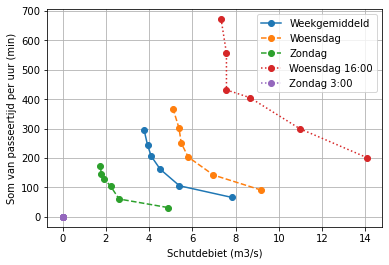

In [350]:
plt.plot(W_week.values, T_week.values, label='Weekgemiddeld', marker='o')
plt.plot(W_day.loc[3], T_day.loc[3], label='Woensdag', marker='o', ls='--')
plt.plot(W_day.loc[7], T_day.loc[7], label='Zondag', marker='o', ls='--')
plt.plot(W_hour.loc[(3, 14)], T_hour.loc[(3, 14)], label='Woensdag 16:00', marker='o', ls=':')
plt.plot(W_hour.loc[(7, 3)], T_hour.loc[(7, 3)], label='Zondag 3:00', marker='o', ls=':')
plt.grid()
plt.xlabel('Schutdebiet (m3/s)')
plt.ylabel('Som van passeertijd per uur (min)')
plt.legend()

plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_per_tijdseenheid.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_per_tijdseenheid.svg', bbox_inches='tight')

In [351]:
def compute_regime_per_hour(Q_available):

    T_at_hours = {}
    R_at_hours = {}

    for hour in W_hour.index:

        W = W_hour.loc[hour][::-1]
        T = T_hour.loc[hour][::-1]

        T_at_hour = np.interp(Q_available, W, T)
        R_at_hour = len(T) - np.interp(Q_available, W, range(len(T)))


        T_at_hours[hour] = T_at_hour
        R_at_hours[hour] = R_at_hour


    T_at_hours = pd.Series(T_at_hours)
    R_at_hours = pd.Series(R_at_hours)
    return T_at_hours, R_at_hours

In [352]:
def compute_regime_per_day(Q_available):

    T_on_days = {}
    R_on_days = {}

    for day in W_day.index:

        W = W_day.loc[day][::-1]
        T = T_day.loc[day][::-1]

        T_on_day = np.interp(Q_available, W, T)
        R_on_day = len(T) - np.interp(Q_available, W, range(len(T)))


        T_on_days[day] = T_on_day
        R_on_days[day] = R_on_day


    T_on_days = pd.Series(T_on_days)
    R_on_days = pd.Series(R_on_days)
    return T_on_days, R_on_days

In [353]:
def compute_regime_per_week(Q_available):
    W = W_week[::-1]
    T = T_week[::-1]
    
    T_for_week = np.interp(Q_available, W, T)
    R_for_week = len(T) - np.interp(Q_available, W, range(len(T)))
    return T_for_week, R_for_week

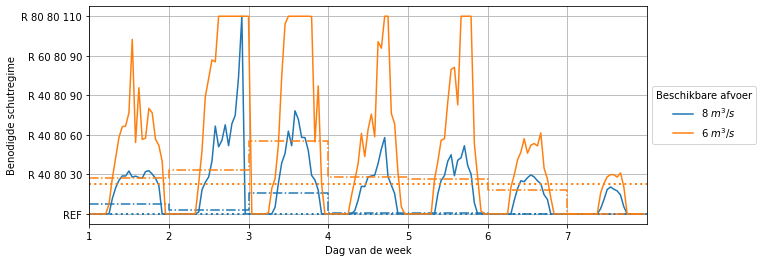

In [423]:
Q_availables = [8, 6]

plt.figure(figsize=(10, 4))
for Q_available, color in zip(Q_availables, ['C0', 'C1', 'C2']):

    T_at_hours, R_at_hours = compute_regime_per_hour(Q_available)
    R_at_hours.plot(label=f'{Q_available} $m^3/s$', c=color)
    
    T_on_days, R_on_days = compute_regime_per_day(Q_available)
    
    plotdata = R_on_days.append(pd.Series({8: R_on_days.loc[7]}))
    plotdata.index=(plotdata.index-1) * 24
    
    plt.plot(plotdata.index, plotdata.values, drawstyle='steps-post', c=color, ls='-.')
    
    T_for_week, R_for_week = compute_regime_per_week(Q_available)
    plt.axhline(R_for_week, c=color, lw=2, ls=':')
    

plt.yticks(ticks=np.arange(len(scenario_names)) + 1, labels=scenario_names)
plt.grid()
plt.legend(title='Beschikbare afvoer', loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale(tight=True, axis='x')
plt.xticks(ticks=np.arange(0, 7*24, 24), labels=np.arange(7)+1)  
plt.xlabel('Dag van de week')
plt.ylabel('Benodigde schutregime')

plt.savefig(    outputdir / f'{lock}_Schutregime_per_uur.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Schutregime_per_uur.svg', bbox_inches='tight')

In [424]:
def get_watertekort(R_at_hours):
    # Uren met zwaarst schutregime
    ii = R_at_hours == len(scenario_names)

    # Watertekort tijdens deze uren
    watertekort = W_hour.iloc[:, -1] - Q_available
    watertekort[~ii] = 0
    
    return watertekort

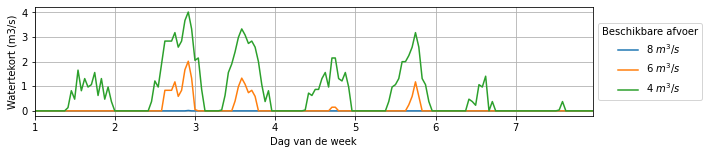

In [426]:
# Watertekort
Q_availables = [8, 6, 4]


plt.figure(figsize=(10, 2))
for Q_available, color in zip(Q_availables, ['C0', 'C1', 'C2']):

    T_at_hours, R_at_hours = compute_regime_per_hour(Q_available)
    
    watertekort = get_watertekort(R_at_hours)

    watertekort.plot(label=f'{Q_available} $m^3/s$', c=color)
    
plt.grid()
plt.legend(title='Beschikbare afvoer', loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale(tight=True, axis='x')
plt.xticks(ticks=np.arange(0, 7*24, 24), labels=np.arange(7)+1)  
plt.xlabel('Dag van de week')
plt.ylabel('Watertekort (m3/s)')

plt.savefig(    outputdir / f'{lock}_Watertekort_per_uur.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Watertekort_per_uur.svg', bbox_inches='tight')

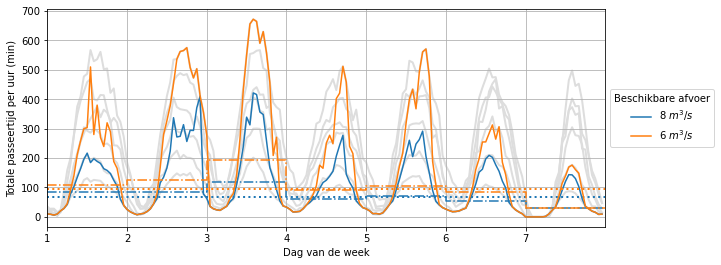

In [440]:
Q_availables = [8, 6]
plt.figure(figsize=(10, 4))


for Q_available, color in zip(Q_availables, ['C0', 'C1', 'C2']):

    T_at_hours, R_at_hours = compute_regime_per_hour(Q_available)
    T_at_hours.plot(label=f'{Q_available} $m^3/s$', c=color)
    
    T_on_days, R_on_days = compute_regime_per_day(Q_available)
    
    plotdata = T_on_days.append(pd.Series({8: T_on_days.loc[7]}))
    plotdata.index=(plotdata.index-1) * 24
    
    plt.plot(plotdata.index, plotdata.values, drawstyle='steps-post', c=color, ls='-.')
    
    T_for_week, R_for_week = compute_regime_per_week(Q_available)
    plt.axhline(T_for_week, c=color, lw=2, ls=':')
    

# plt.yticks(ticks=np.arange(len(scenario_names)) + 1, labels=scenario_names)
legend1 = plt.legend(title='Beschikbare afvoer', loc='center left', bbox_to_anchor=(1, 0.5))

T_hour.plot(c='#DDDDDD', legend=None, zorder=-3, ax=plt.gca(), lw=2)
plt.gca().get_legend().remove()
plt.grid()
plt.gca().add_artist(legend1)
plt.autoscale(tight=True, axis='x')
plt.xticks(ticks=np.arange(0, 7*24, 24), labels=np.arange(7)+1)  
plt.xlabel('Dag van de week')
plt.ylabel('Totale passeertijd per uur (min)')

plt.savefig(    outputdir / f'{lock}_Passeertijd_per_uur.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Passeertijd_per_uur.svg', bbox_inches='tight')

In [441]:
Q_availables_range = np.linspace(0, 20, 101)

T_increase = {}
watertekort = {}

for Q_available in Q_availables_range:

    T_at_hours, R_at_hours = compute_regime_per_hour(Q_available)    
    T_on_days, R_on_days = compute_regime_per_day(Q_available)        
    T_for_week, R_for_week = compute_regime_per_week(Q_available)
    
    Ttot_hour = T_at_hours.sum()
    Ttot_day = (T_on_days * 24).sum()
    Ttot_week = (T_for_week * 24 * 7)
    
    T_increase[Q_available] = Ttot_hour / Ttot_week
    
    watertekort[Q_available] = get_watertekort(R_at_hours).mean()
    
T_increase = pd.Series(T_increase)
watertekort = pd.Series(watertekort)

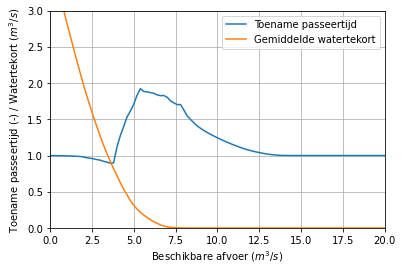

In [443]:
T_increase.plot(label='Toename passeertijd')
watertekort.plot(label='Gemiddelde watertekort')
plt.grid()
plt.ylabel('Toename passeertijd (-) / Watertekort ($m^3/s$)')
plt.ylim(0, 3)
plt.autoscale(tight=True, axis='x')
plt.legend(loc='upper right')
plt.xlabel('Beschikbare afvoer ($m^3/s$)')

plt.savefig(    outputdir / f'{lock}_Toename_passeertijd.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Toename_passeertijd.svg', bbox_inches='tight')

## Born

In [474]:
# Read instances for all runs in dict
lock = 'Born'
scenario_names = ['REF', 'R 40 80 30', 'R 40 80 60', 'R 40 80 90', 'R 60 80 90', 'R 80 80 110']
S = {}
for name in scenario_names:
    
    scenario = {v:k for k,v in simulations[lock].items()}[name]
    
    summary_file =       inputdir / lock / 'KPI LockChambers Summary' / f'KPI_LockChambers_Summary_Avg ({scenario}).csv'
    ships_file =         inputdir / lock / 'Log Generated Ships' / f'Log Generated Ships ({scenario}).csv'
    levelings_file =     inputdir / lock / 'Log Locks Leveling' / f'Log Locks Leveling ({scenario}).csv'
    transit_times_file = inputdir / lock / 'Log Locks Transit Times' / f'Log Locks Transit Times ({scenario}).csv'

    s = pySIVAK(levelings_file, transit_times_file, ships_file, summary_file)

    s.correction_waitingtimes_without_new_arrivals(maximum_waiting_time=maximum_waiting_time[name])
    s.correction_leveling_without_utilization()
    s.correction_waterloss(water_plane=settings['water_plane'][lock], dH=settings['dH'][lock], downward_leveling_side=1, correct_ship_volume=False)

    s.name = name
    
    S[name] = s

In [475]:
W_hour = {}
W_day = {}
W_week = {}

T_hour = {}
T_day = {}
T_week = {}

for name, s in S.items():

    waterloss = s.waterloss_per_hour_per_day()
    waterloss_rolling = get_rolling(waterloss)
    
    total_passage_time = s.passage_time_per_hour_per_day_per_ship_sum().sum(axis=1).unstack().fillna(0)
    total_passage_time_rolling = get_rolling(total_passage_time)
    
    # Per unit of time
    W_hour[name] = waterloss_rolling
    W_day[name]  = waterloss_rolling.mean(level=0)
    W_week[name] = waterloss_rolling.mean()
    
    
    # Per unit of time
    T_hour[name] = total_passage_time_rolling
    T_day[name]  = total_passage_time_rolling.mean(level=0)
    T_week[name] = total_passage_time_rolling.mean()
    
    
W_hour = pd.concat(W_hour, axis=1)
W_day  = pd.concat(W_day, axis=1)
W_week = pd.Series(W_week)    

T_hour = pd.concat(T_hour, axis=1)
T_day  = pd.concat(T_day, axis=1)
T_week = pd.Series(T_week)

In [476]:
# Toevoegen scenario's met pompen
Q_pomp = settings['max_pomp_inzet'][lock]

scenarios_with_pumps = -4

all_scenario_new = []
for scenario in scenario_names[scenarios_with_pumps:]:
    scenario_new = scenario + ' P 12'
    
    # Minder waterbesparing
    W_hour[scenario_new] = W_hour[scenario] - Q_pomp
    W_day [scenario_new] = W_day[scenario] - Q_pomp
    W_week[scenario_new] = W_week[scenario] - Q_pomp
    
    # Gelijke tijden
    T_hour[scenario_new] = T_hour[scenario]
    T_day [scenario_new] = T_day[scenario]
    T_week[scenario_new] = T_week[scenario]
    all_scenario_new.append(scenario_new)

# Delete old scenarios that should not be used
scenarios_keep = scenario_names[:scenarios_with_pumps+1] + all_scenario_new

W_hour = W_hour[scenarios_keep]
W_day  = W_day [scenarios_keep] 
W_week = W_week[scenarios_keep]

T_hour = T_hour[scenarios_keep]
T_day  = T_day [scenarios_keep]
T_week = T_week[scenarios_keep]

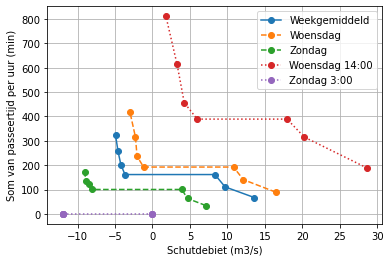

In [477]:
plt.plot(W_week.values, T_week.values, label='Weekgemiddeld', marker='o')
plt.plot(W_day.loc[3], T_day.loc[3], label='Woensdag', marker='o', ls='--')
plt.plot(W_day.loc[7], T_day.loc[7], label='Zondag', marker='o', ls='--')
plt.plot(W_hour.loc[(3, 14)], T_hour.loc[(3, 14)], label='Woensdag 14:00', marker='o', ls=':')
plt.plot(W_hour.loc[(7, 3)], T_hour.loc[(7, 3)], label='Zondag 3:00', marker='o', ls=':')
plt.grid()
plt.xlabel('Schutdebiet (m3/s)')
plt.ylabel('Som van passeertijd per uur (min)')
plt.legend()

                                        
plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_per_tijdseenheid.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Laagwaterbeleid_per_tijdseenheid.svg', bbox_inches='tight')

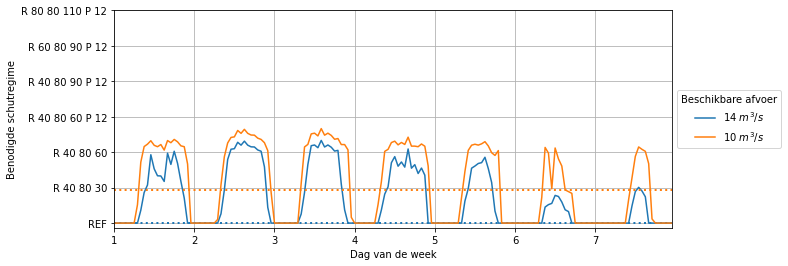

In [545]:
Q_availables = [14, 10]

plt.figure(figsize=(10, 4))
for Q_available, color in zip(Q_availables, ['C0', 'C1', 'C2']):

    T_at_hours, R_at_hours = compute_regime_per_hour(Q_available)
    R_at_hours.plot(label=f'{Q_available} $m^3/s$', c=color)
    
    T_on_days, R_on_days = compute_regime_per_day(Q_available)
    
#     plotdata = R_on_days.append(pd.Series({8: R_on_days.loc[7]}))
#     plotdata.index=(plotdata.index-1) * 24
    
#     plt.plot(plotdata.index, plotdata.values, drawstyle='steps-post', c=color, ls='-.')
    
    T_for_week, R_for_week = compute_regime_per_week(Q_available)
    plt.axhline(R_for_week, c=color, lw=2, ls=':')
    

plt.yticks(ticks=np.arange(len(T_week.index)) + 1, labels=scenarios_keep)
plt.grid()
plt.legend(title='Beschikbare afvoer', loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale(tight=True, axis='x')
plt.xticks(ticks=np.arange(0, 7*24, 24), labels=np.arange(7)+1)  
plt.xlabel('Dag van de week')
plt.ylabel('Benodigde schutregime')

plt.savefig(    outputdir / f'{lock}_Schutregime_per_uur.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Schutregime_per_uur.svg', bbox_inches='tight')

In [509]:
def get_pompinzet(R_at_hours):
    return (R_at_hours - scen_with_pumps).clip(0, 1) * Q_pomp

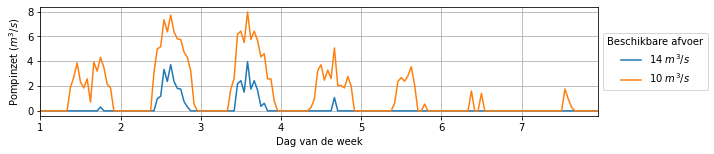

In [506]:
# Pompinzet
Q_availables = [14, 10]
scen_with_pumps = len(scenarios_keep) + scenarios_with_pumps

plt.figure(figsize=(10, 2))
for Q_available, color in zip(Q_availables, ['C0', 'C1', 'C2']):

    T_at_hours, R_at_hours = compute_regime_per_hour(Q_available)
    
    pompinzet = get_pompinzet(R_at_hours)

    pompinzet.plot(label=f'{Q_available} $m^3/s$', c=color)
    
plt.grid()
plt.legend(title='Beschikbare afvoer', loc='center left', bbox_to_anchor=(1, 0.5))
plt.autoscale(tight=True, axis='x')
plt.xticks(ticks=np.arange(0, 7*24, 24), labels=np.arange(7)+1)  
plt.xlabel('Dag van de week')
plt.ylabel('Pompinzet ($m^3/s$)')

plt.savefig(    outputdir / f'{lock}_Pompinzet_per_uur.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Pompinzet_per_uur.svg', bbox_inches='tight')

In [540]:
Q_availables_range = np.linspace(0, 20, 101)

T_increase = {}
pompinzet_uur = {}
pompinzet_week = {}

for Q_available in Q_availables_range:

    T_at_hours, R_at_hours = compute_regime_per_hour(Q_available)    
    T_on_days, R_on_days = compute_regime_per_day(Q_available)        
    T_for_week, R_for_week = compute_regime_per_week(Q_available)
    
    Ttot_hour = T_at_hours.sum()
    Ttot_day = (T_on_days * 24).sum()
    Ttot_week = (T_for_week * 24 * 7)
    
    T_increase[Q_available] = Ttot_hour / Ttot_week
    
    pompinzet_uur[Q_available] = get_pompinzet(R_at_hours).mean()
    pompinzet_week[Q_available] = get_pompinzet(R_for_week)
    
T_increase = pd.Series(T_increase)
pompinzet_uur = pd.Series(pompinzet_uur)
pompinzet_week = pd.Series(pompinzet_week)

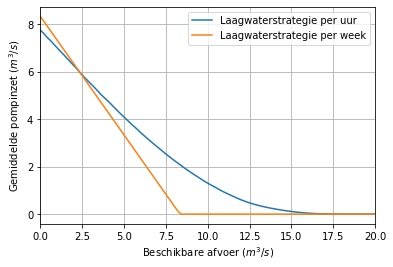

In [544]:
pompinzet_uur.plot(label='Laagwaterstrategie per uur')
pompinzet_week.plot(label='Laagwaterstrategie per week')
plt.ylabel('Gemiddelde pompinzet ($m^3/s$)')
plt.grid()
plt.autoscale(tight=True, axis='x')
plt.legend(loc='upper right')
plt.xlabel('Beschikbare afvoer ($m^3/s$)')

plt.savefig(    outputdir / f'{lock}_Toename_pompinzet.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Toename_pompinzet.svg', bbox_inches='tight')

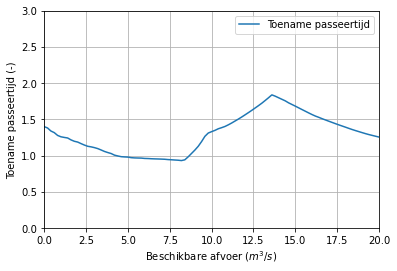

In [535]:
T_increase.plot(label='Toename passeertijd')
plt.grid()
plt.ylabel('Toename passeertijd (-)')
# plt.ylabel('Toename passeertijd (-)')
plt.ylim(0, 3)
plt.autoscale(tight=True, axis='x')
plt.legend(loc='upper right')
plt.xlabel('Beschikbare afvoer ($m^3/s$)')

plt.savefig(    outputdir / f'{lock}_Toename_passeertijd.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'{lock}_Toename_passeertijd.svg', bbox_inches='tight')